In [1]:
from transformers import GPT2LMHeadModel

# 0. exploring the GPT-2 (124M) OpenAI checkpoint

In [2]:
# use model_hf = GPT2LMHeadModel.from_pretrained("gpt2-xl") for the largest model
model_hf = GPT2LMHeadModel.from_pretrained("gpt2") # 124M
sd_hf = model_hf.state_dict()

for k, v in sd_hf.items():
    print(k, v.shape)

# wte: 
# weights for token embedding. 50257 vocab, 768 dimensions. 
# lookup table for tokens
# h.0-11, 12 layers

# wpe: 
# weights for posistion embedding. 
# max sequence length 1024,
# up to 1024 positions each token can be attending to in the past. 
# every one of the positions has a fixed vector of 768, which is learned by optimization
# lookup table for the positions


transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

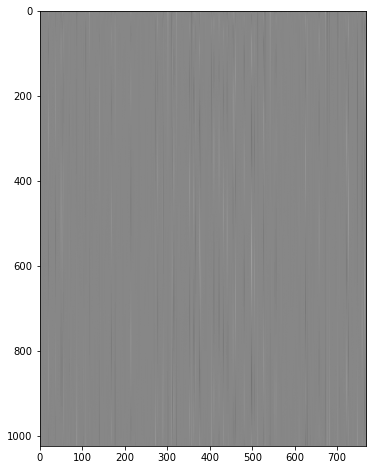

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 8)) 

plt.imshow(sd_hf["transformer.wpe.weight"], cmap="gray")

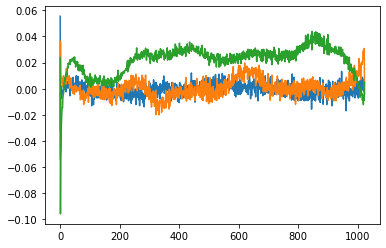

In [4]:
plt.plot(sd_hf["transformer.wpe.weight"][:, 129])
plt.plot(sd_hf["transformer.wpe.weight"][:, 200])
plt.plot(sd_hf["transformer.wpe.weight"][:, 250])

# They are a bit jagged/nosiy, which means the model is not fully trained.
# But in principle, these curves don't have to be smooth. 
# can be totally random noise in the begining, since they are only the first 250.
# In the original transformer paper, the position enbedding are initialized and fixed 
# to sinusoids and cosiness of different frequencies. 
# In GPT2 the position enbedding are parameters and trained from scratch.

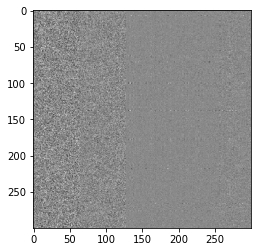

In [5]:
plt.imshow(sd_hf["transformer.h.1.attn.c_attn.weight"][:300,:300], cmap="gray")

In [6]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Hello, I'm a language model, but what I'm really doing is making a human-readable document. There are other languages, but those are"},
 {'generated_text': "Hello, I'm a language model, not a syntax model. That's why I like it. I've done a lot of programming projects.\n"},
 {'generated_text': "Hello, I'm a language model, and I'll do it in no time!\n\nOne of the things we learned from talking to my friend"},
 {'generated_text': "Hello, I'm a language model, not a command line tool.\n\nIf my code is simple enough:\n\nif (use (string"},
 {'generated_text': "Hello, I'm a language model, I've been using Language in all my work. Just a small example, let's see a simplified example."}]

# SECTION 1: implementing the GPT-2 nn.Module

In [14]:
# let's instead sample manually
import torch
from torch.nn import functional as F

model = GPT2LMHeadModel.from_pretrained("gpt2") # 124M
model.eval()
# model.to('cuda')
model.to('mps')
torch.manual_seed(42)
# torch.cuda.manual_seed(42)
torch.mps.manual_seed(42)
tokens = [15496, 11, 314, 1101, 257, 3303, 2746, 11] # "Hello, I'm a language model,"
tokens = torch.tensor(tokens, dtype=torch.long) # (8,)
tokens = tokens.unsqueeze(0).repeat(5, 1) # (5, 8)
# x = tokens.to('cuda')
x = tokens.to('mps')

# generate!
while x.size(1) < 30: # max_length=30
    # forward the model to get the logits
    with torch.no_grad():
        logits = model(x)[0] # (B, T, vocab_size)
        # take the logits at the last position
        logits = logits[:, -1, :] # (B, vocab_size)
        # get the probabilities
        probs = F.softmax(logits, dim=-1)
        # do top-k sampling of 50 (huggingface pipeline default)
        # topk_probs here becomes (5, 50), topk_indices is (5, 50)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        # select a token from the top-k probabilities
        # note: multinomial does not demand the input to sum to 1
        ix = torch.multinomial(topk_probs, 1) # (B, 1)
        # gather the corresponding indices
        xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
        # append to the sequence
        x = torch.cat((x, xcol), dim=1)

# print the generated text
import tiktoken
enc = tiktoken.get_encoding('gpt2')
for i in range(5):
    tokens = x[i, :30].tolist()
    decoded = enc.decode(tokens)
    print(">", decoded)

> Hello, I'm a language model, or I am I speak I am am I am am I am am an I am am am am am am
> Hello, I'm a language model, a'm a

 a, a, a, I a, a me a a my, me a
> Hello, I'm a language model, a, I am a I, a, I am a I a a a, a a a is a
> Hello, I'm a language model, a. I and, I'm a a an a


 a
 a a, a, a
> Hello, I'm a language model, I'm I'm I'm I my I'm I
 I am I I I my<|endoftext|> I I I


### let’s train: data batches (B,T) → logits (B,T,C)

In [15]:
# tiny shakespeare dataset
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r') as f:
    text = f.read()
data = text[:1000] # first 1,000 characters
print(data[:100])

# gpt2 tokenizer has a compression ratio of roughly 3:1.

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [16]:
import tiktoken
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode(data)
print(tokens[:24])

[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248, 461, 11, 2740, 13]


In [17]:
import torch
buf = torch.tensor(tokens[:24 + 1])
x = buf[:-1].view(4, 6) # andrej's fav way!
y = buf[1:].view(4, 6)
print(x)
print(y)

tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])
tensor([[22307,    25,   198,  8421,   356,  5120],
        [  597,  2252,    11,  3285,   502,  2740],
        [   13,   198,   198,  3237,    25,   198],
        [ 5248,   461,    11,  2740,    13,   198]])


In [22]:
# lm head at the top of the transformer
print(sd_hf["lm_head.weight"].shape)
# token embedding at the bottom of transformer
print(sd_hf["transformer.wte.weight"].shape)

# identical in the element wise
print((sd_hf["lm_head.weight"] == sd_hf["transformer.wte.weight"]).all())

# point to the identical tensor in the data storage
print(sd_hf["lm_head.weight"].data_ptr())
print(sd_hf["transformer.wte.weight"].data_ptr())

torch.Size([50257, 768])
torch.Size([50257, 768])
tensor(True)
140173034651648
140173034651648


In [24]:
# standard deviation grows inside the residual stream
x = torch.zeros(768)
n = 100 # e.g. 100 layers
for i in range(n):
    x += torch.randn(768)
    # x += n**-0.5 * torch.randn(768)

print(x.std())

tensor(10.3244)


In [25]:
tensor = torch.tensor([1.0, 2.0, 3.0], dtype=torch.float32, device='mps')

In [26]:
tensor

tensor([1., 2., 3.], device='mps:0')

In [1]:
import sympy
print(sympy.__version__)

1.13.1


In [28]:
pip install --upgrade sympy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 12.0 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: sympy
    Found existing installation: sympy 1.6.2
    Uninstalling sympy-1.6.2:
      Successfully uninstalled sympy-1.6.2

[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
